# Studying mobility changes due to covid 19 political measures

#### simple PCA analysis

input:
- df_param as Google_mobility_fit_df_param 

no output

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyodbc as pyo
import time
from datetime import datetime
from dateutil.parser import  *
import itertools

import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True) 
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn import decomposition

In [2]:
url = "https://raw.githubusercontent.com/sylvainhislaire/projects/master/Google_Mobility_raw_df.csv"
df = pd.read_csv(url, header = [0,1], index_col = [0])
df

Country           Afghanistan                                        \
Sector     Grocery & pharmacy Parks Residential Retail & recreation   
date                                                                  
2020-02-15              -10.0   0.0        -5.0                -9.0   
2020-02-16               11.0   1.0        -0.0                 3.0   
2020-02-17               11.0   2.0         1.0                 6.0   
2020-02-18                5.0   3.0         1.0                 3.0   
2020-02-19                3.0   1.0        -1.0                -1.0   
...                       ...   ...         ...                 ...   
2020-04-13              -27.0 -13.0       -14.0               -46.0   
2020-04-14              -32.0 -14.0       -15.0               -48.0   
2020-04-15              -31.0 -10.0       -14.0               -42.0   
2020-04-16              -34.0 -13.0       -16.0               -46.0   
2020-04-17              -21.0 -12.0       -11.0               -41.0   

Country                                           Angola                    \
Sector     Transit stations Workplace Grocery & pharmacy Parks Residential   
date                                                                         
2020-02-15             -2.0     -28.0               -2.0   7.0        -1.0   
2020-02-16             10.0       4.0                0.0 -11.0        -2.0   
2020-02-17              9.0       5.0               -4.0   2.0        -0.0   
2020-02-18              9.0       6.0               -4.0  -4.0         1.0   
2020-02-19              0.0       5.0              -12.0  -3.0        -1.0   
...                     ...       ...                ...   ...         ...   
2020-04-13            -51.0     -41.0              -40.0 -39.0       -29.0   
2020-04-14            -52.0     -42.0              -35.0 -40.0       -27.0   
2020-04-15            -51.0     -42.0              -40.0 -41.0       -29.0   
2020-04-16            -51.0     -39.0              -34.0 -36.0       -25.0   
2020-04-17            -51.0     -13.0              -37.0 -43.0       -31.0   

Country                         ...      Zambia                      \
Sector     Retail & recreation  ... Residential Retail & recreation   
date                            ...                                   
2020-02-15                 3.0  ...        -4.0                -1.0   
2020-02-16                -4.0  ...        -3.0                -4.0   
2020-02-17                -6.0  ...        -3.0                -8.0   
2020-02-18                -3.0  ...        -2.0                -6.0   
2020-02-19               -10.0  ...        -3.0                -8.0   
...                        ...  ...         ...                 ...   
2020-04-13               -55.0  ...       -21.0               -32.0   
2020-04-14               -52.0  ...       -11.0               -16.0   
2020-04-15               -54.0  ...       -13.0               -19.0   
2020-04-16               -52.0  ...       -12.0               -18.0   
2020-04-17               -56.0  ...       -13.0               -23.0   

Country                                         Zimbabwe                    \
Sector     Transit stations Workplace Grocery & pharmacy Parks Residential   
date                                                                         
2020-02-15             -5.0       7.0                0.0  -1.0        -1.0   
2020-02-16             -7.0       2.0               -3.0  -6.0        -3.0   
2020-02-17             -8.0       8.0               -2.0  -1.0        -1.0   
2020-02-18             -4.0       6.0                4.0   0.0        -2.0   
2020-02-19             -7.0       4.0                1.0  -4.0        -1.0   
...                     ...       ...                ...   ...         ...   
2020-04-13            -32.0     -51.0              -63.0 -51.0       -49.0   
2020-04-14            -20.0     -16.0              -53.0 -47.0       -41.0   
2020-04-15            -25.0     -18.0              -50.0 -5

In [3]:
url = "https://raw.githubusercontent.com/sylvainhislaire/projects/master/Google_Mobility_fit_df_param.csv"
df_param = pd.read_csv(url, header = [0,1], index_col = [0])
df_param

Country               Afghanistan                                             \
Sector         Grocery & pharmacy      Parks Residential Retail & recreation   
parameters                                                                     
acuteness               10.000000   0.624789    0.284801            0.319800   
transition day          41.857616  40.362680   41.173570           39.386526   
intensity              -29.895426 -14.646242  -12.959441          -46.476161   
offset                   4.095363   2.463956   -0.674879            0.798643   
error                   32.298828   5.601513    3.371539           18.888179   

Country                                                Angola             \
Sector         Transit stations  Workplace Grocery & pharmacy      Parks   
parameters                                                                 
acuteness              0.209542   3.089872          10.000000   0.323832   
transition day        38.719832  41.621038          40.946044  37.074623   
intensity            -52.000000 -35.980899         -37.516984 -45.320953   
offset                 4.622126   1.085921           1.707271   4.925963   
error                 22.668155  90.130409          52.949917  42.287646   

Country                                         ...      Zambia  \
Sector         Residential Retail & recreation  ... Residential   
parameters                                      ...               
acuteness         0.420756            3.043538  ...    0.245632   
transition day   37.654515           40.501179  ...   41.888258   
intensity       -27.296113          -51.716102  ...  -11.148057   
offset           -0.171635           -3.703236  ...   -2.364054   
error            15.765583           77.804041  ...    5.859250   

Country                                                          \
Sector         Retail & recreation Transit stations   Workplace   
parameters                                                        
acuteness                 0.200000         0.200000    0.200000   
transition day           41.499351        41.417020   44.821920   
intensity               -22.289023       -21.916520  -27.602718   
offset                    0.170077        -3.577105    4.490555   
error                    35.274266        18.709830  123.015129   

Country                  Zimbabwe                                             \
Sector         Grocery & pharmacy      Parks Residential Retail & recreation   
parameters                                                                     
acuteness               10.000000   0.468455    0.498078           10.000000   
transition day          43.519254  42.017633   41.400674           43.415239   
intensity              -60.424010 -46.444337  -40.921894          -63.639418   
offset                   5.093659  -3.868086   -1.326554           -2.683319   
error                   33.668760  35.943083   21.148464           41.060552   

Country                                      
Sector         Transit stations   Workplace  
parameters                                   
acuteness             10.000000    0.599979  
transition day        43.584050   42.457331  
intensity            -65.611296  -68.743481  
offset               -13.860382    4.346077  
error                 43.221788  193.039495  

[5 rows x 775 columns]

In [4]:
sectors = list(df_param.groupby('Sector',axis=1).min().columns.get_level_values('Sector'))
countries = list(df_param.groupby('Country',axis=1).min().columns.get_level_values('Country'))
sectors

['Grocery & pharmacy',
 'Parks',
 'Residential',
 'Retail & recreation',
 'Transit stations',
 'Workplace']

### filling values in the dataset (all countries do not have 6 sectors)

#### finding incorrect and missing values

In [5]:
# finding Nan values in original dataset
for i in df_param:
    for j in df_param[i]:
        if j != j:
            print(i)

('Guinea-Bissau', 'Grocery & pharmacy')
('Liechtenstein', 'Transit stations')


In [6]:
df_param['Guinea-Bissau']

Sector,Grocery & pharmacy,Parks,Retail & recreation,Workplace
parameters,,,,
acuteness,0.200217,0.334193,0.200000,0.424183
transition day,0.000999,35.155300,31.497936,36.957646
intensity,-6.248544,-12.945721,-53.433707,-33.054701
offset,-6.237073,-10.993339,-4.317520,-2.677836
error,NaN,23.547987,31.617966,88.527928


#### here I simply exclude these countries. See below for further analysis

In [7]:
# find and delete countries with less than 6 sectors
to_be_deleted = []

for country in countries:
    if len(df[country].columns) < 6:
        print(country + ' ' + str(len(df[country].columns)))
        to_be_deleted.append(country)
        
df_param_clean = df_param.drop(to_be_deleted,axis=1)

Guinea-Bissau 4
Liechtenstein 4
Réunion 5


In [8]:
# find and delete NaN values
to_be_deleted = []

for column in df_param_clean:
    for i in df_param_clean[column]:
        if i != i:
            print(column)
            to_be_deleted.append(column[0])
            
df_param_clean = df_param_clean.drop(to_be_deleted,axis=1)

### now back to the pca

#### normalising and centering the data

In [9]:
X = df_param_clean.transpose().reset_index('Sector').pivot(columns='Sector')
X

parameters                   acuteness                         \
Sector              Grocery & pharmacy      Parks Residential   
Country                                                         
Afghanistan                  10.000000   0.624789    0.284801   
Angola                       10.000000   0.323832    0.420756   
Antigua and Barbuda          10.000000   0.200000    0.396819   
Argentina                    10.000000   0.405857    0.691398   
Aruba                         0.220844   0.482337    0.444646   
...                                ...        ...         ...   
Venezuela                     1.399607   0.806661    1.493675   
Vietnam                       0.340003   0.200000    0.353560   
Yemen                        10.000000   0.339830    0.391589   
Zambia                        3.519566  10.000000    0.245632   
Zimbabwe                     10.000000   0.468455    0.498078   

parameters                                                          \
Sector              Retail & recreation Transit stations Workplace   
Country                                                              
Afghanistan                    0.319800         0.209542  3.089872   
Angola                         3.043538         0.319943  0.435809   
Antigua and Barbuda            0.200000         0.206991  0.215458   
Argentina                      0.538336         0.671672  1.061981   
Aruba                          0.386600         0.288523  0.347621   
...                                 ...              ...       ...   
Venezuela                      1.092437         1.481133  3.644635   
Vietnam                        0.249809         0.200000  0.673311   
Yemen                          0.226827         0.309555  0.200000   
Zambia                         0.200000         0.200000  0.200000   
Zimbabwe                      10.000000        10.000000  0.599979   

parameters              transition day                         \
Sector              Grocery & pharmacy      Parks Residential   
Country                                                         
Afghanistan                  41.857616  40.362680   41.173570   
Angola                       40.946044  37.074623   37.654515   
Antigua and Barbuda          46.491289  40.372261   31.662594   
Argentina                    33.795974  29.440728   31.795877   
Aruba                        38.103240  31.651704   31.068580   
...                                ...        ...         ...   
Venezuela                    31.083857  29.281635   29.833479   
Vietnam                      41.101127  38.171971   40.716705   
Yemen                        37.523667  33.448287   35.263459   
Zambia                       10.785162   2.071450   41.888258   
Zimbabwe                     43.519254  42.017633   41.400674   

parameters                               ...      offset                      \
Sector              Retail & recreation  ... Residential Retail & recreation   
Country                                  ...                                   
Afghanistan                   39.386526  ...   -0.674879            0.798643   
Angola                        40.501179  ...   -0.171635           -3.703236   
Antigua and Barbuda           41.616746  ...   -0.739536           -0.178886   
Argentina                     31.163765  ...   -0.264951           -0.222552   
Aruba                         30.032808  ...   -0.839422            2.327211   
...                                 ...  ...         ...                 ...   
Venezuela                     29.626160  ...    0.008227            4.066943   
Vietnam                       38.917187  ...   -5.719351           -9.715687   
Yemen                         30.594762  ...   -1.085641            4.289854   
Zambia                        41.499351  ...   -2.364054            0.170077   
Zimbabwe                      43.415239  ...   -1.326554           -2.683319   

parameters                                                  error           

In [10]:
for i in X:
    X[i] = (X[i] - np.mean(X[i])) / np.std(X[i])
X

parameters                   acuteness                        \
Sector              Grocery & pharmacy     Parks Residential   
Country                                                        
Afghanistan                   1.471320 -0.529871   -0.348075   
Angola                        1.471320 -0.608337   -0.269746   
Antigua and Barbuda           1.471320 -0.640622   -0.283538   
Argentina                     1.471320 -0.586951   -0.113818   
Aruba                        -0.860074 -0.567011   -0.255982   
...                                ...       ...         ...   
Venezuela                    -0.579051 -0.482453    0.348406   
Vietnam                      -0.831666 -0.640622   -0.308461   
Yemen                         1.471320 -0.604166   -0.286551   
Zambia                       -0.073644  1.914447   -0.370643   
Zimbabwe                      1.471320 -0.570630   -0.225198   

parameters                                                          \
Sector              Retail & recreation Transit stations Workplace   
Country                                                              
Afghanistan                   -0.414294        -0.380735  0.720427   
Angola                         0.877405        -0.317284 -0.394730   
Antigua and Barbuda           -0.471107        -0.382201 -0.487315   
Argentina                     -0.310655        -0.115136 -0.131632   
Aruba                         -0.382615        -0.335342 -0.431784   
...                                 ...              ...       ...   
Venezuela                     -0.047880         0.350084  0.953521   
Vietnam                       -0.447486        -0.386219 -0.294939   
Yemen                         -0.458385        -0.323255 -0.493810   
Zambia                        -0.471107        -0.386219 -0.493810   
Zimbabwe                       4.176421         5.246115 -0.325751   

parameters              transition day                        \
Sector              Grocery & pharmacy     Parks Residential   
Country                                                        
Afghanistan                   0.968013  0.913007    1.126154   
Angola                        0.866947  0.599842    0.688596   
Antigua and Barbuda           1.481747  0.913920   -0.056437   
Argentina                     0.074221 -0.127234   -0.039864   
Aruba                         0.551766  0.083346   -0.130296   
...                                ...       ...         ...   
Venezuela                    -0.226471 -0.142387   -0.283868   
Vietnam                       0.884141  0.704357    1.069347   
Yemen                         0.487509  0.254458    0.391293   
Zambia                       -2.476983 -2.733972    1.215018   
Zimbabwe                      1.152239  1.070630    1.154392   

parameters                               ...      offset                      \
Sector              Retail & recreation  ... Residential Retail & recreation   
Country                                  ...                                   
Afghanistan                    1.144614  ...   -0.067831            0.134484   
Angola                         1.332796  ...    0.180604           -0.974634   
Antigua and Barbuda            1.521133  ...   -0.099750           -0.106347   
Argentina                     -0.243602  ...    0.134537           -0.117105   
Aruba                         -0.434537  ...   -0.149060            0.511074   
...                                 ...  ...         ...                 ...   
Venezuela                     -0.503190  ...    0.269395            0.939689   
Vietnam                        1.065377  ...   -2.558112           -2.455909   
Yemen                         -0.339665  ...   -0.270610            0.994607   
Zambia                         1.501313  ...   -0.901718           -0.020374   
Zimbabwe                       1.824765  ...   -0.389540           -0.723359   

parameters                                                  error            \
Sector              Trans

In [11]:
Xpca = X.to_numpy()

number of componants: 8
explained variance per component: [0.22310365 0.15943661 0.10239884 0.0815621  0.06545651 0.04490163
 0.04286793 0.03866482]
total explained variance: 0.7583921018274334


Text(0.5, 1.0, 'Cumulative proportion of variance explained')

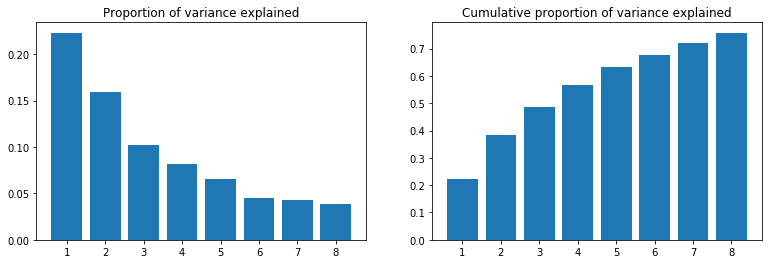

In [12]:
pca = decomposition.PCA(n_components=0.75)
pca.fit(X)
Xpca = pca.transform(X)
print('number of componants: ' + str(pca.n_components_))
print('explained variance per component: ' + str(pca.explained_variance_ratio_))
print('total explained variance: ' + str(sum(pca.explained_variance_ratio_)))

plt.figure(figsize = (13,4))
plt.subplot(1,2, 1)
plt.bar(range(1,pca.n_components_+1),pca.explained_variance_ratio_)
plt.title('Proportion of variance explained')

plt.subplot(1,2, 2)
data = []
for i in range(1,pca.n_components_+1):
    data.append(sum(pca.explained_variance_ratio_[0:i]))
plt.bar(range(1,pca.n_components_+1),data)
plt.title('Cumulative proportion of variance explained')

In [13]:
df_pc = pd.DataFrame(Xpca, columns = ['1st','2nd','3rd','4th','5th','6th','7th','8th'])
fig = px.scatter_3d(df_pc, x='1st', y='2nd', z='3rd',
              color='4th')
fig.show()

In [14]:
titles = []
for i in range(len(X.columns)):
    title = ''
    for j in [0,1]:
        title += list(X.columns)[i][j]
        if j ==0:
            title+= ', '
    titles.append(title)

<BarContainer object of 30 artists>

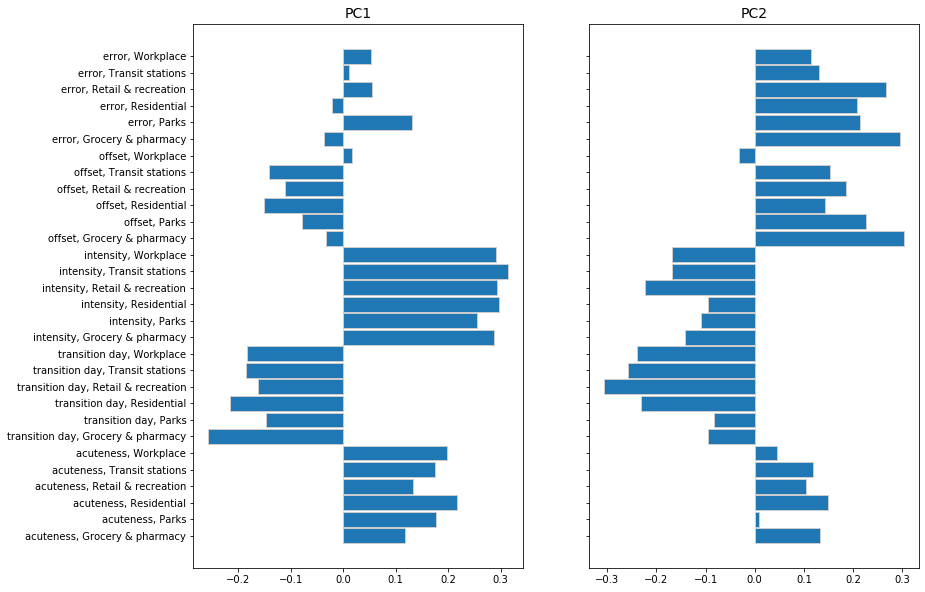

In [15]:
# composition of first principal component  
#plt.figure(figsize = (13,8)).suptitle('Composition of Principal components',size=16)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (13,10),sharey = True)

#ax=plt.subplot(1,2,1)
ax1.set_title('PC1',size=14)
ax1.barh(titles,pca.components_[0],height = 0.9,edgecolor='#cccccc')

#ax=plt.subplot(1,2,2)
ax2.set_title('PC2',size=14)
#ax2.tick_params('x',direction ='in')
ax2.barh(titles,pca.components_[1],height = 0.9,edgecolor='#cccccc')


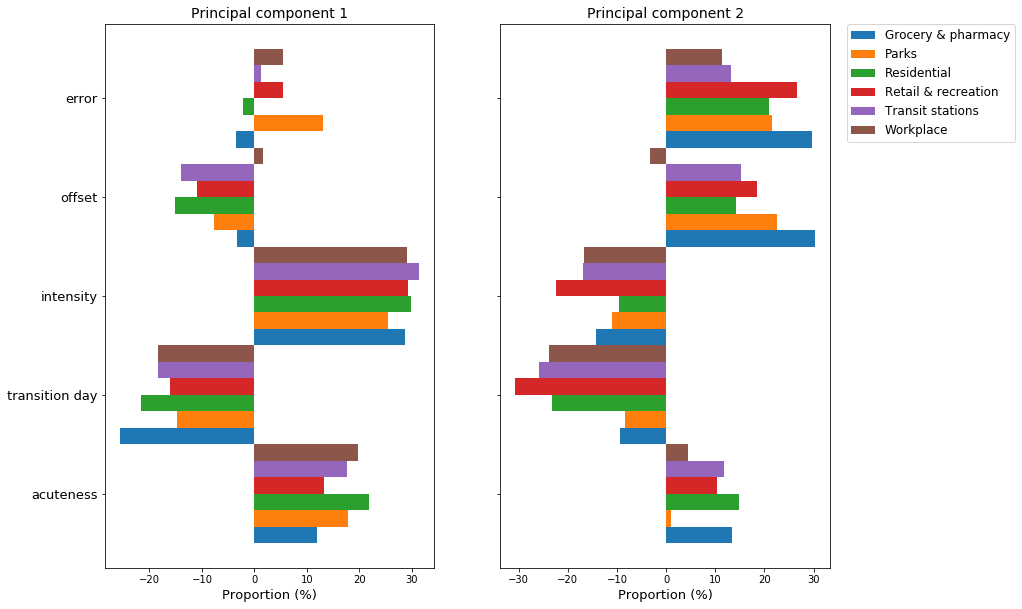

In [16]:
# same graph than the previous one
labels = list(df_param.index)

fig, ax = plt.subplots(1, 2,figsize = (13,10),sharey = True)

x = np.arange(len(labels))  # the label locations
width = 1/6  # the width of the bars  

for j in [0,1]:
    
    pc_compo = []
    for i in range(len(sectors)):
        pc_compo.append((pca.components_[j]*100)[np.array(range(i,30,6))[:]])
        ax[j].barh(x - 2*width-width/2+i/6, pc_compo[i], width, label=sectors[i])
  
    ax[j].set_xlabel('Proportion (%)',size=13)
    ax[j].set_title('Principal component ' + str(j+1),size=14)
    ax[j].set_yticks(x)
    ax[j].set_yticklabels(labels,size=13)

    if j == 1:
        ax[j].legend(fontsize = 12,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

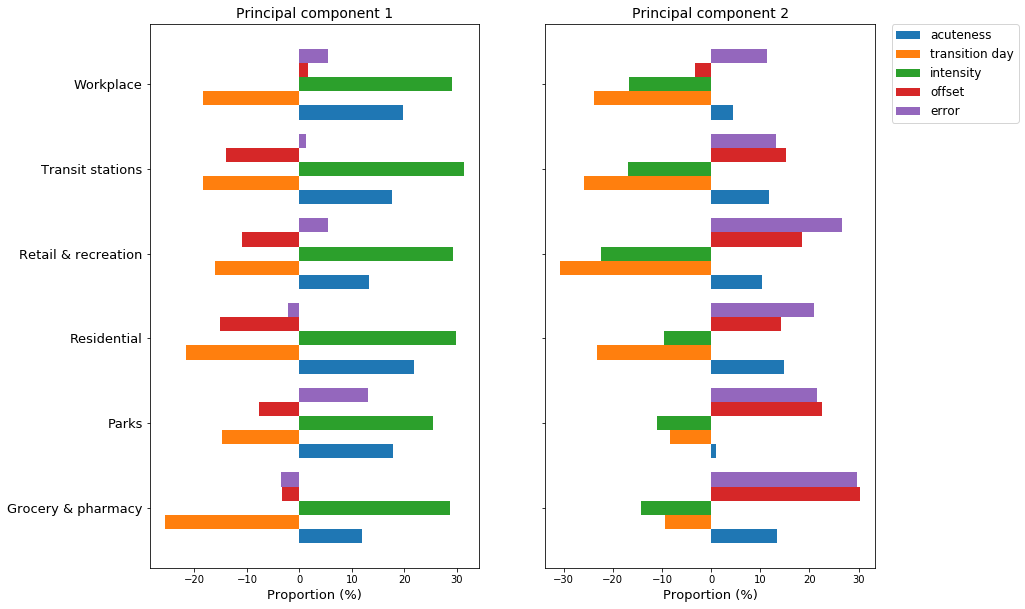

In [17]:
labels = sectors

fig, ax = plt.subplots(1, 2,figsize = (13,10),sharey = True)

x = np.arange(len(labels))  # the label locations
width = 1/6  # the width of the bars  

for j in [0,1]:
    
    pc_compo = []
    for i in range(len(list(df_param.index))):
        pc_compo.append((pca.components_[j]*100)[np.array(range(0,6))[:]+6*i])
        ax[j].barh(x - 2*width+i/6, pc_compo[i], width, label=df_param.index[i])
  
    ax[j].set_xlabel('Proportion (%)',size=13)
    ax[j].set_title('Principal component ' + str(j+1),size=14)
    ax[j].set_yticks(x)
    ax[j].set_yticklabels(labels,size=13)

    if j == 1:
        ax[j].legend(fontsize = 12,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)